<h1 align="center">Tarea 1 Minería de datos</h1>
<center>Matías Campos (201173536-6)<br>
Esteban Díaz (201173509-9)</center>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering as HAC
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist, pdist
import time

In [2]:
#Lectura del dataset
df = pd.read_csv('beer_reviews/beer_reviews.csv', header = 0)

## Descripción del dataset

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
brewery_id            1586614 non-null int64
brewery_name          1586599 non-null object
review_time           1586614 non-null int64
review_overall        1586614 non-null float64
review_aroma          1586614 non-null float64
review_appearance     1586614 non-null float64
review_profilename    1586266 non-null object
beer_style            1586614 non-null object
review_palate         1586614 non-null float64
review_taste          1586614 non-null float64
beer_name             1586614 non-null object
beer_abv              1518829 non-null float64
beer_beerid           1586614 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.518829e+06,1.586614e+06
mean,3.130099e+03,1.224089e+09,3.815581e+00,3.735636e+00,3.841642e+00,3.743701e+00,3.792860e+00,7.042387e+00,2.171279e+04
std,5.578104e+03,7.654427e+07,7.206219e-01,6.976167e-01,6.160928e-01,6.822184e-01,7.319696e-01,2.322526e+00,2.181834e+04
min,1.000000e+00,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,3.000000e+00
25%,1.430000e+02,1.173224e+09,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.717000e+03
50%,4.290000e+02,1.239203e+09,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.390600e+04
75%,2.372000e+03,1.288568e+09,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.944100e+04
max,2.800300e+04,1.326285e+09,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731700e+04


El dataset utilizado proviene de la página web www.beeradvocate.com. En sus foros se publican reviews de cervezas (utilizando el sistema de puntuación establecido para ello) con el fin de entregar información objetiva los consumidores. 

El dataset contiene más de 1.500.000 reviews. Los siguientes atributos corresponden al sistema de puntuación, estos se miden en una escala de 1 a 5 con incremetos de 0.25:
<ul>
<li><b>review_overall:</b> Describe la impresión general de la cerveza.
<li><b>review_aroma:</b> Describe malta, lúpulos, levaduras u otros aromas.
<li><b>review_appearance:</b> Describe el color, claridad, espuma y marcas que deja la cerveza.
<li><b>review_palate:</b> Describe el cuerpo, carbonatación, tibiedad, cremosidad, astringencia y otras sensaciones al paladar.
<li><b>review_taste:</b> Describe malta, lúpulos, fermentación, balance, gusto posterior y otras características del sabor.
<li><b>beer_abv:</b> Puntaje promedio.
</ul>

Cada ejemplo también cuenta con datos relacionados al producto y el usuario.
<ul>
<li><b>brewery_id:</b>ID de la cervecería (entero).
<li><b>beer_beerid:</b>ID de la cerveza (entero).
<li><b>brewery_name:</b> Nombre de la cervecería (texto).
<li><b>review_time:</b> (entero)
<li><b>review_profilename:</b> Nombre del usuario (texto).
<li><b>beer_style:</b> Tipo de cerveza (texto).
<li><b>beer_name:</b> Nombre de la cerveza (texto)
</ul>

## Test de algoritmos de clustering

Para visualizar los resultados de los distintos algoritmos de clustering, se proyectó el dataset a un manifold 2D utilizando Spectral Embedding.
Dado el tamaño del dataset se optó por trabajar con el 0.01% de este, debido a que se obtuvieron errores de memoria a utilizar porcentajes mayores que éste.

### a) K-Means

Debido a la naturaleza del algoritmo se descartaron todas las características en formato de texto (brewery_name, review_profilename, beer_style, beer_name). Además se descartaron los ejemplos con valores nulos y se estandarizaron los datos, debido a que no todos se encuentran en la misma escala.

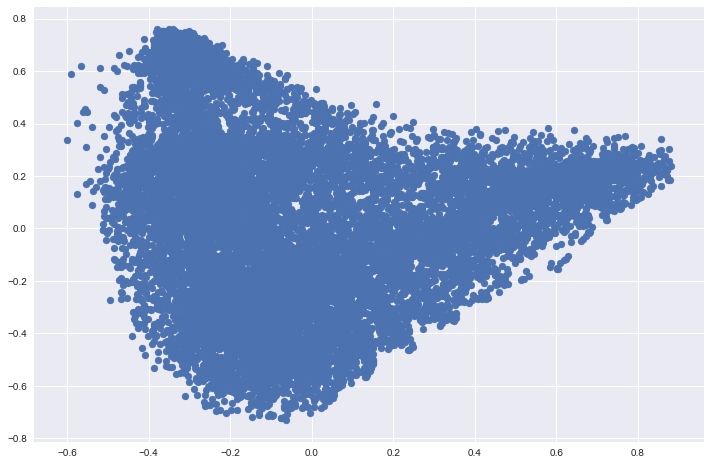

In [4]:
#Eliminación de características con formato de texto
df = df.drop('brewery_name', axis=1)
df = df.drop('review_profilename', axis=1)
df = df.drop('beer_style', axis=1)
df = df.drop('beer_name', axis=1)
#df = df.drop('brewery_id',axis=1)
#df = df.drop('beer_beerid',axis=1)
#df = df.drop('review_time',axis=1)

#Selección aleatoria de la muestra original 
df = df.sample(frac=.01)

#Eliminación de valores nulos y normalización
df = df[np.isfinite(df['beer_abv'])]
df = StandardScaler().fit_transform(df)

X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(df)
plt.figure(figsize=(12, 8))
plt.scatter(X_red[:, 0],X_red[:, 1])
plt.show()

Uno de las desventajas del algoritmo Kmeans es que se debe entregar como parámetro el número de clusters. Para determinar este parámetro se utilizó el elbow method.

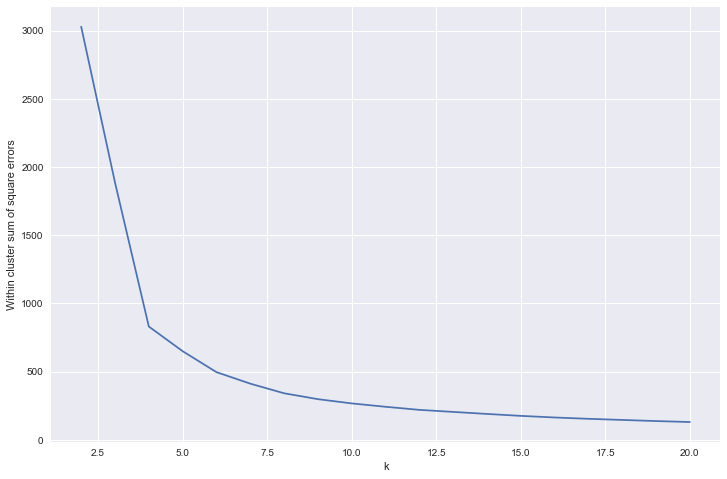

In [5]:
def elbow(df, n_clusters):
    kMeansVar = [KMeans(n_clusters=k).fit(df) for k in range(1, n_clusters)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(df, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    plt.figure(figsize=(12, 8))
    plt.plot(range(2,21),wcss)
    plt.ylabel('Within cluster sum of square errors')
    plt.xlabel('k')
    plt.show()
    
elbow(X_red,20)

Del gráfico anterior se concluye que los mejores valores de k se encuentra dentro del intervalo [2,6]. Dado que se obtuvo un rango de valores, se analizó el Silhouette Score para cada uno de ellos. Éste score, mide la similitud entre un ejemplo con el cluster al que pertence, y también con los k-1 restantes. Su valor se encuentran dentro del intervalo [-1, 1], en donde un valor cercano a 1 indica una alta similaridad.

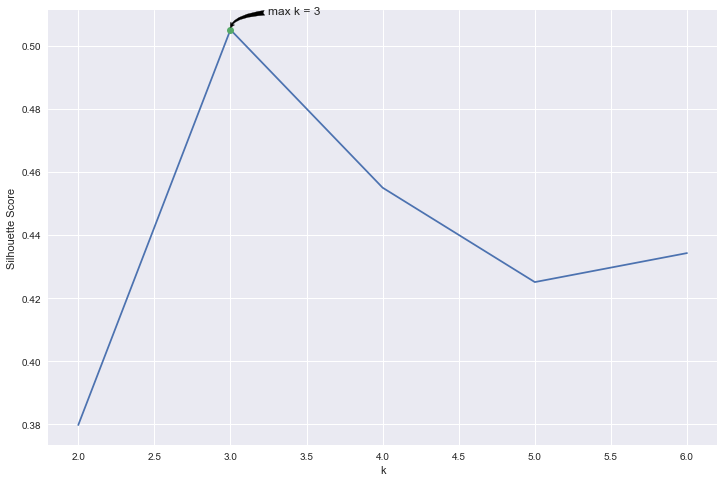

In [6]:
sc = []
for n_clusters in range(2,7):
    kmeans = KMeans(n_clusters=n_clusters).fit(X_red)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    sc.append(silhouette_score(X_red, labels, metric='euclidean'))

plt.figure(figsize=(12, 8))
plt.plot(range(2,7),sc)
plt.plot(np.argmax(sc)+2, np.amax(sc),'o')
plt.annotate('max k = 3', xy=(np.argmax(sc)+2, np.amax(sc)), xytext=(3.25, 0.51),
            arrowprops=dict(facecolor='black', arrowstyle = 'fancy',
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.ylabel("Silhouette Score")
plt.xlabel("k")
sns.despine()
plt.show()

En el gráfico se observa que el Silhouette Score alcanza un valor máximo en k = 3, y luego decae drásticamente para valores mayores de k, lo que indica que la cohesión de los clusters disminuye al aumentar su cantidad.

In [7]:
print("Max Silhouette Score = {} (k = {})" ).format(np.amax(sc),np.argmax(sc)+2)

Max Silhouette Score = 0.505172845224 (k = 3)


In [8]:
t0 = time.time()
kmeans = KMeans(n_clusters=3).fit(X_red)
t_kmeans = time.time() - t0

### b)  Mini Batch K-Means

In [9]:
t0 = time.time()
mbkmeans = MiniBatchKMeans(n_clusters=3).fit(X_red)
t_mbkmeans = time.time() - t0

### c) HAC Complete

In [10]:
t0 = time.time()
hac = HAC(n_clusters=3,linkage='complete').fit(X_red)
t_hac = time.time() - t0

### d) Ward

In [11]:
t0 = time.time()
ward = HAC(n_clusters=3,linkage='ward').fit(X_red)
t_ward = time.time() - t0

### e) DBSCAN

In [34]:
t0 = time.time()
dbscan = DBSCAN(eps=0.0115).fit(X_red)
t_dbscan = time.time() - t0

El parámetro eps se obtuvo utilizando K-dist plot. Se observa que el valor apropiado se encuentra en el rango (0.01,0.013).

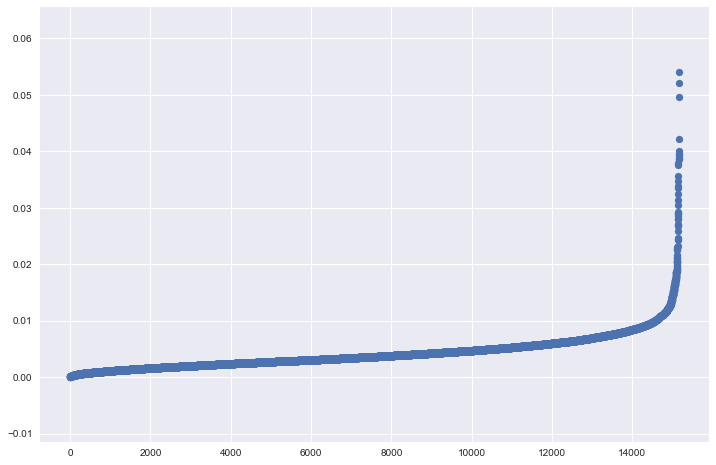

In [14]:
#Nearest neighbors
nbrs = NearestNeighbors(n_neighbors=len(X_red)).fit(X_red)
distances, indices = nbrs.kneighbors(X_red)

#Recorrer distancias
mins = []
for i in distances:
    #Encontrar mínimo > 0
    m = min(j for j in i if j > 0)
    mins.append(m)
    
plt.figure(figsize=(12, 8))
plt.scatter(range(0,len(mins)), sorted(mins))
plt.show()

## Comparación de técnicas utilizadas

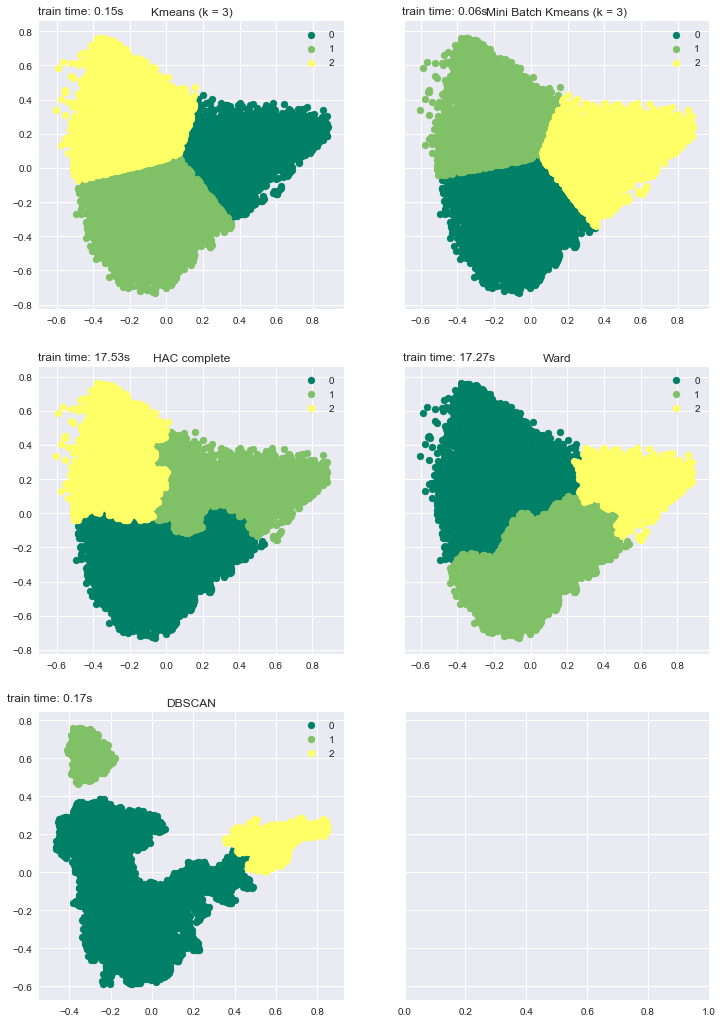

In [35]:
#Representación de resultados para los distintos algoritmos, junto a su tiempo de entrenamiento.
techniques = {"Kmeans (k = 3)":[0,0,kmeans.labels_,t_kmeans], 
              "Mini Batch Kmeans (k = 3)":[0,1,mbkmeans.labels_,t_mbkmeans],
              "HAC complete":[1,0,hac.labels_,t_hac],
              "Ward":[1,1,ward.labels_,t_ward],
              "DBSCAN":[2,0,dbscan.labels_,t_dbscan]
             }

f, axarr = plt.subplots(3, 2,sharey='row',figsize=(12, 18))
cmap = plt.cm.get_cmap('summer')
mclasses=(0,1,2)
mcolors = [cmap(i) for i in np.linspace(0,1,3)]

for key, value in techniques.iteritems():
    axarr[value[0],value[1]].set_title(key)
    for lab, col in zip(mclasses,mcolors):
        axarr[value[0],value[1]].scatter(X_red[value[2]==lab, 0],X_red[value[2]==lab, 1],
                                         label=lab,c=col)
    axarr[value[0],value[1]].legend(loc='upper right', fancybox=True)
    axarr[value[0],value[1]].text(-0.7, 0.9, 'train time: %.2fs' %
         (value[3]))

plt.show()

Se puede observar que los métodos con menor tiempo de entrenamiento corresponden a Kmeans y Mini Batch Kmeans, siendo este último levemente más rápido debido a que procesa el dataset por lotes. En el gráfico a continuación se observan las diferencias entre ambos métodos.

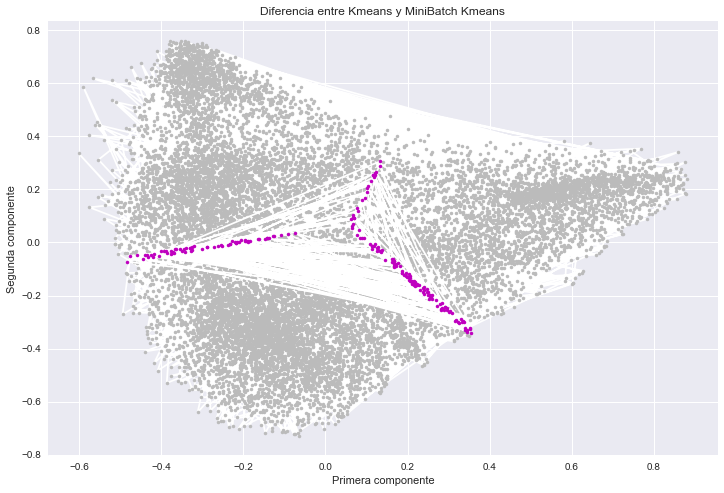

In [36]:
#Código obtenido de http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html

order = pairwise_distances_argmin(kmeans.cluster_centers_,
                                  mbkmeans.cluster_centers_)
# Initialise the different array to all False
different = (mbkmeans.labels_ == 4)

for k in range(3):
    different += ((kmeans.labels_ == k) != (mbkmeans.labels_ == order[k]))

identic = np.logical_not(different)
plt.figure(figsize=(12, 8))
plt.plot(X_red[identic, 0], X_red[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
plt.plot(X_red[different, 0], X_red[different, 1], 'w',
        markerfacecolor='m', marker='.')
plt.title('Diferencia entre Kmeans y MiniBatch Kmeans')
plt.ylabel("Segunda componente")
plt.xlabel("Primera componente")
plt.show()

En los casos de HAC Complete y Ward se observan mayores diferencias, sin embargo, la distribución se mantiene de manera similar.

Por otro lado, los clusters obtenidos por DBSCAN pierden una cantidad de información importante. Esto es un comportamiento esperado debido a que la densidad de los datos está distribuida de una manera prácticamente uniforme y la cantidad de datos es elevada. Estas dos condiciones impiden que el algoritmo sea apropiado.

## Análisis
Dado lo anterior, resta determinar si es cuales son los atributos que describen a los clusters como etiquetas de clase. 

En los primeros cuatro métodos se observan 3 clusters que dividen la muestra en partes relativamente similares, por lo que se analizarán los resultados obtenidos en K-means obteniendo los valores medios de cada atributo para cada cluster.

In [112]:
columns = ["brewery_id","review_time","review_overall","review_aroma","review_appearance","review_palate","review_taste","beer_abv","beer_beerid"]

In [115]:
km_labels = kmeans.predict(X_red)
clusters = {}
n = 0
for item in km_labels:
    if item in clusters:
        clusters[item].append(df[n])
    else:
        clusters[item] = [df[n]]
    n +=1

for item in clusters:
    print "Cluster: " + str(item+1)
    for idx, column in enumerate(columns):
        print "["+column+"]: " + str(round(np.mean(clusters[item][idx]),2)) + "\t",
    print "\n"


Cluster: 1
[brewery_id]: -0.64	[review_time]: -0.72	[review_overall]: -1.23	[review_aroma]: -0.29	[review_appearance]: -0.68	[review_palate]: -0.42	[review_taste]: -0.61	[beer_abv]: -1.35	[beer_beerid]: -0.64	

Cluster: 2
[brewery_id]: 0.15	[review_time]: 0.32	[review_overall]: 0.12	[review_aroma]: -0.26	[review_appearance]: 0.04	[review_palate]: -0.25	[review_taste]: 0.02	[beer_abv]: 0.5	[beer_beerid]: 0.47	

Cluster: 3
[brewery_id]: 0.32	[review_time]: 0.57	[review_overall]: 0.86	[review_aroma]: 0.4	[review_appearance]: 0.65	[review_palate]: 0.46	[review_taste]: 0.38	[beer_abv]: 0.15	[beer_beerid]: 0.34	



Dado lo anterior, se observa que el Cluster 3 concentra las mejores revisiones, mientras que el 1 posee las peores. Finalmente puede decirse que la clusterización permitió separar las cervezas por calidad.